In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import time, os, io
from scipy import stats
from si_prefix import si_format
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from qcodes.instrument.base import Instrument

def udu_list(amp, stp):
    n  =  np.round(amp/stp)    
    u1 = np.linspace (0, amp, n + 1)
    d = np.linspace (amp, -amp, 2*n +1)
    u2 = np.linspace (-amp, 0, n + 1)
    return np.concatenate ([u1, d, u2])

from qcodes.instrument_drivers.Keithley.Keithley_2400 import Keithley_2400

In [22]:
try:
    Instrument.close_all()
except KeyError:
    pass
except NameError:
    pass

K2400 =  Keithley_2400(name = 'K2400', address = "GPIB::25::INSTR" )
K2400.reset()

K2400.write(':SYST:RSEN ON')

K2400.compliancev.set(21)
K2400.mode.set('CURR')
K2400.rangei.set(1e-7)
K2400.sense.set('VOLT')
K2400.rangev.set(1e-3)

K2400.output.set(1)

print('Keithley 2400 configured ready. Please un-shunt the sample now.')

Keithley 2400 configured ready. Please un-shunt the sample now.


In [41]:
K2400.output.set(1)

SampleID = 'Q111M2_1_4-4p'

ilst = udu_list(amp=1e-7, stp=1e-8)
vlst = np.asarray([])

for i in ilst:
    K2400.curr.set(i)
    time.sleep(0.1)
    v = K2400.volt.get()
    #v = 1e26*i**3
    vlst = np.append(vlst,v)
    
ivDF = pd.DataFrame(data  = { 'I':pd.Series(ilst), 'V':pd.Series(vlst) })
dir_path = os.getcwd()
savepath = dir_path+r"\data\{}{}{}-{}-{}{}{}.txt".format(
                    time.localtime()[0]%100, time.localtime()[1], time.localtime()[2],
                    SampleID,
                    time.localtime()[3],     time.localtime()[4], time.localtime()[5])
with open(savepath, 'w+') as f:
    ivDF.to_csv(f)

C:\Users\plame\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Users\plame\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  
C:\Users\plame\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


In [42]:
#ivDF

<IPython.core.display.Javascript object>


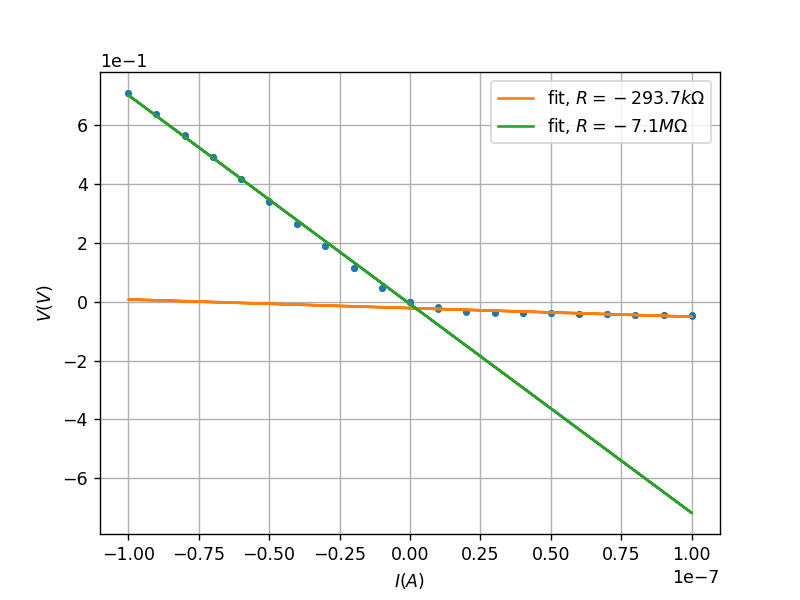

In [52]:
#loadpath=savepath
loadpath = 'data/19126-Q111M2_1_2-4p-1761.txt'

SampleID = 'Q111M2_1_2-4p'

with open(loadpath, 'r') as f:
    ivloadDF = pd.read_csv(f)

plt.close('all')
f,ax = plt.subplots()
ax.plot(ivloadDF['I'],ivloadDF['V'],'.')

slope, intercept, r_value, p_value, std_err = stats.linregress(ivloadDF['I'][0:20],ivloadDF['V'][0:20])
x = ivloadDF['I']
ax.plot(x, slope*x+intercept,'-',label = 'fit, $R = {}\Omega$'.format(si_format(slope)))

slopel, interceptl, r_valuel, p_valuel, std_errl = stats.linregress(ivloadDF['I'][20:40],ivloadDF['V'][20:40])
xl = ivloadDF['I']
ax.plot(xl, slopel*x+interceptl,'-',label = 'fit, $R = {}\Omega$'.format(si_format(slopel)))

ax.legend()
ax.set_xlabel('$I (A)$')
ax.set_ylabel('$V (V)$')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0, 2))
ax.grid()
plt.show()

plt.savefig(SampleID+'.png')